In [8]:
import sys
sys.path.append('./stylegan/stylegan2')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.nn import functional as F

from cifar10_models.densenet import densenet121, densenet161, densenet169
from cifar10_models.googlenet import googlenet
from cifar10_models.inception import inception_v3
from cifar10_models.mobilenetv2 import mobilenet_v2
from cifar10_models.resnet import resnet18, resnet34, resnet50
from cifar10_models.vgg import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn
from temperature_scaling import ModelWithTemperature, _ECELoss
from general_calibration_error import gce
from dirichletcal.calib.vectorscaling import VectorScaling
from uncertainty_metrics import AURC_calc, AUROC, ECE_calc, coverage_for_desired_accuracy

for p in [
    Path('/d/alecoz/projects'), # DeepLab
    Path(os.path.expandvars('$WORK')), # Jean Zay
    Path('w:/')]: # local
    if os.path.exists(p):
        path_main = p
# path_results = path_main / 'uncertainty-conditioned-gan/results'
for p in [
    Path('/scratchf/CIFAR'), # DeepLab
    Path(os.path.expandvars('$DSDIR'))]: # Jean Zay
    if os.path.exists(p):
        path_dataset = p
path_models = Path.cwd().parent / 'models' / 'CIFAR10'

## Load data

In [2]:
batch_size = 128

idx_to_label = {
    0: 'airplane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer', 
    5: 'dog', 
    6: 'frog', 
    7: 'horse', 
    8: 'ship',
    9: 'truck'}

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
transforms = T.Compose(
    [T.ToTensor(),
    T.Normalize(mean, std)])
dataset_train = CIFAR10(root=path_dataset, train=True, transform=transforms)
dataset_val = CIFAR10(root=path_dataset, train=False, transform=transforms)
dataset_calib, dataset_test = torch.utils.data.random_split(dataset_val, [5000, 5000], generator=torch.Generator().manual_seed(123))
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_calib = DataLoader(dataset_calib, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, pin_memory=True)

## Calibration utils

In [3]:
def metrics_from_dataloader(model, dataloader, vector_scale=None):
    # First: collect all the logits and labels for the validation set
    logits_list = []
    labels_list = []
    for input, label in dataloader:
        input = input.cuda()
        with torch.no_grad():
            logits = model(input)
        logits_list.append(logits)
        labels_list.append(label)
    logits = torch.cat(logits_list).cpu()
    if vector_scale is not None:
        probs = torch.from_numpy(vector_scale.predict_proba(logits).copy())
    else:
        probs = torch.softmax(logits, dim=1)
    labels = torch.cat(labels_list).cpu()
    
    certainties, y_pred = probs.max(axis=1)
    correct = y_pred == labels
    samples_certainties = torch.stack((certainties.cpu(), correct.cpu()), dim=1)
    
    # Second: compute calibration metrics
    metrics = {}
    metrics['ECE'] = gce(labels, probs, binning_scheme='even', class_conditional=False, max_prob=True, norm='l1', num_bins=15)
    metrics['SCE'] = gce(labels, probs, binning_scheme='even', class_conditional=False, max_prob=False, norm='l1', num_bins=15)
    metrics['RMSCE'] = gce(labels, probs, binning_scheme='adaptive', class_conditional=False, max_prob=True, norm='l2', datapoints_per_bin=100)
    metrics['ACE'] = gce(labels, probs, binning_scheme='adaptive', class_conditional=True, max_prob=False, norm='l1')
    metrics['TACE'] = gce(labels, probs, binning_scheme='adaptive', class_conditional=True, max_prob=False, norm='l1', threshold=0.01)
    
    # Third: compute uncertainty metrics
    metrics['Accuracy'] = (samples_certainties[:,1].sum() / samples_certainties.shape[0]).item() * 100
    metrics['AUROC'] = AUROC(samples_certainties)
    metrics['Coverage_for_Accuracy_99'] = coverage_for_desired_accuracy(samples_certainties, accuracy=0.99, start_index=200)
    # metrics[f'ECE_15'], mce = ECE_calc(samples_certainties, num_bins=15)
    metrics['AURC'] = AURC_calc(samples_certainties)
    
    return metrics


def hist_from_dataloader(model, dataloader, vector_scale=None):
    n_bins = 15
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
        
    logits_list = []
    labels_list = []
    for input, label in dataloader:
        input = input.cuda()
        with torch.no_grad():
            logits = model(input)
        logits_list.append(logits)
        labels_list.append(label)
    logits = torch.cat(logits_list).cuda()
    labels = torch.cat(labels_list).cuda()
    
    if vector_scale is not None:
        softmaxes = torch.from_numpy(vector_scale.predict_proba(logits.cpu())).to(logits.device)
    else:
        softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    if labels.dim() > 1:
        if labels.shape[1] > 1: # one-hot embedding
            labels = labels.argmax(1)
    accuracies = predictions.eq(labels)

    accuracies_in_bin = []
    avg_confidences_in_bin = []
    data_in_bin = []
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
        else:
            accuracy_in_bin = float('nan')
            avg_confidence_in_bin = float('nan')
        accuracies_in_bin.append(accuracy_in_bin)
        avg_confidences_in_bin.append(avg_confidence_in_bin)
        data_in_bin.append(100*in_bin.cpu().sum()/len(in_bin)) # in %
            
    avg_confidences_in_bin = torch.as_tensor(avg_confidences_in_bin)
    accuracies_in_bin = torch.as_tensor(accuracies_in_bin)
    data_in_bin = torch.as_tensor(data_in_bin)
            
    return avg_confidences_in_bin, accuracies_in_bin, data_in_bin, bin_boundaries

In [4]:
models = {
    # 'densenet121': densenet121, 'densenet161': densenet161, 'densenet169': densenet169,
    # 'googlenet': googlenet,
    # 'inception_v3': inception_v3,
    # 'mobilenet_v2': mobilenet_v2,
    'resnet18': resnet18, 'resnet34': resnet34, 'resnet50':resnet50, 
    # 'vgg11_bn': vgg11_bn, 'vgg13_bn': vgg13_bn, 'vgg16_bn': vgg16_bn, 'vgg19_bn':vgg19_bn
    }

methods = ['baseline (no calibration)', 'temperature scaling', 'vector scaling']

## Benchmark methods on several metrics and models

In [ ]:
results_calib = []
results_test = []

for model_name, model in models.items():
    print(model_name)
    classifier = model(pretrained=True).eval().requires_grad_(False).cuda()
    
    for method in methods:
        if method == 'baseline (no calibration)':
            metrics_calib = metrics_from_dataloader(classifier, dataloader_calib)
            metrics_test = metrics_from_dataloader(classifier, dataloader_test)
        elif method == 'temperature scaling':
            classifier_calibrated = ModelWithTemperature(classifier).cuda()
            classifier_calibrated.set_temperature(dataloader_calib)
            metrics_calib = metrics_from_dataloader(classifier_calibrated, dataloader_calib)
            metrics_test = metrics_from_dataloader(classifier_calibrated, dataloader_test)
        elif method == 'vector scaling':
            # Fit vector scaling
            vs = VectorScaling(logit_input=True, logit_constant=0.0)
            logits_list = []
            labels_list = []
            for input, label in dataloader_calib:
                input = input.cuda()
                with torch.no_grad():
                    logits = classifier(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cpu()
            labels = torch.cat(labels_list).cpu()
            vs.fit(logits.numpy(), labels.numpy())
            metrics_calib = metrics_from_dataloader(classifier, dataloader_calib, vs)
            metrics_test = metrics_from_dataloader(classifier, dataloader_test, vs)
        else:
            raise NotImplementedError

        results_calib.append({'model': model_name, 'method': method, **metrics_calib})
        results_test.append({'model': model_name, 'method': method, **metrics_test})

df_results_calib = pd.DataFrame(results_calib)
df_results_test = pd.DataFrame(results_test)

df_results_test

In [ ]:
best_methods = []
for model_name, model in models.items():
    idx_best_method = df_results_test.loc[df_results_test['model'] == model_name, ['ECE', 'SCE', 'RMSCE', 'ACE', 'TACE']].idxmin()
    best_methods.append({'model': model_name, **{k: v for k, v in zip(idx_best_method.index, df_results_test.loc[idx_best_method.values, 'method'].values)}})
df_best_methods = pd.DataFrame(best_methods)
df_best_methods

## Influence of calibration dataset size

In [ ]:
results_calib = []
results_test = []
    
for subset_frac in [0.2, 0.4, 0.6, 0.8, 1]:
    subset_calib_indices = torch.randperm(len(dataset_calib))[:int(subset_frac*len(dataset_calib))]
    subset_calib = Subset(dataset_calib, subset_calib_indices)
    dataloader_calib_subset = DataLoader(subset_calib, batch_size=batch_size, shuffle=True, pin_memory=True)

    for model_name, model in models.items():
        print(model_name)
        classifier = model(pretrained=True).eval().requires_grad_(False).cuda()
        
        for method in methods:
            if method == 'baseline (no calibration)':
                metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_subset)
                metrics_test = metrics_from_dataloader(classifier, dataloader_test)
            elif method == 'temperature scaling':
                classifier_calibrated = ModelWithTemperature(classifier).cuda()
                classifier_calibrated.set_temperature(dataloader_calib_subset)
                metrics_calib = metrics_from_dataloader(classifier_calibrated, dataloader_calib_subset)
                metrics_test = metrics_from_dataloader(classifier_calibrated, dataloader_test)
            elif method == 'vector scaling':
                # Fit vector scaling
                vs = VectorScaling(logit_input=True, logit_constant=0.0)
                logits_list = []
                labels_list = []
                for input, label in dataloader_calib_subset:
                    input = input.cuda()
                    with torch.no_grad():
                        logits = classifier(input)
                    logits_list.append(logits)
                    labels_list.append(label)
                logits = torch.cat(logits_list).cpu()
                labels = torch.cat(labels_list).cpu()
                vs.fit(logits.numpy(), labels.numpy())
                metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_subset, vs)
                metrics_test = metrics_from_dataloader(classifier, dataloader_test, vs)
            else:
                raise NotImplementedError

            results_calib.append({'calib subset size': int(subset_frac*len(dataset_calib)), 'model': model_name, 'method': method, **metrics_calib})
            results_test.append({'calib subset size': int(subset_frac*len(dataset_calib)), 'model': model_name, 'method': method, **metrics_test})

df_results_subsets_calib = pd.DataFrame(results_calib)
df_results_subsets_test = pd.DataFrame(results_test)

df_results_subsets_test

In [ ]:
fig, axs = plt.subplots(len(models), 2, figsize=(10, len(models)*3))

for i, model_name in enumerate(models.keys()):

    for method in methods:
        indices = df_results_subsets_test[(df_results_subsets_test['model'] == model_name) & (df_results_subsets_test['method'] == method)].index
        axs[i, 0].plot(df_results_subsets_test.loc[indices, 'calib subset size'], df_results_subsets_test.loc[indices, 'ECE'], label=method)
        axs[i, 1].plot(df_results_subsets_test.loc[indices, 'calib subset size'], df_results_subsets_test.loc[indices, 'ACE'], label=method)
        axs[i, 0].set_title(model_name)
        axs[i, 0].set_ylabel('ECE')
        axs[i, 1].set_title(model_name)
        axs[i, 1].set_ylabel('ACE')

for ax in axs.flatten():
    ax.legend()
    ax.set_xlabel('calib subset size')

fig.tight_layout()

## Influence of selecting calibration data according to confidence

In [ ]:
model = classifier
dataloader_calib_unshuffled = DataLoader(dataset_calib, batch_size=batch_size, shuffle=False, pin_memory=True)
calib_dataset_size = 2000


logits_list = []
labels_list = []
for input, label in dataloader_calib_unshuffled:
    input = input.cuda()
    with torch.no_grad():
        logits = model(input)
    logits_list.append(logits)
    labels_list.append(label)
logits = torch.cat(logits_list).cpu()
probs = torch.softmax(logits, dim=1)
labels = torch.cat(labels_list).cpu()

certainties = probs.max(axis=1).values
indices_sorting_by_low_confidence = torch.argsort(certainties, descending=False)
indices_sorting_by_high_confidence = torch.argsort(certainties, descending=True)

subset_calib_low_confid = Subset(dataset_calib, indices_sorting_by_low_confidence[:calib_dataset_size])
subset_calib_high_confid = Subset(dataset_calib, indices_sorting_by_high_confidence[:calib_dataset_size])
subset_calib_random_confid = Subset(dataset_calib, torch.randperm(len(dataset_calib))[:calib_dataset_size])

In [ ]:
calib_dataset_size = 2000
dataloader_calib_unshuffled = DataLoader(dataset_calib, batch_size=batch_size, shuffle=False, pin_memory=True)

results_calib = []
results_test = []

for model_name, model in models.items():
    print(model_name)
    classifier = model(pretrained=True).eval().requires_grad_(False).cuda()
    
    # create subsets
    logits_list = []
    labels_list = []
    for input, label in dataloader_calib_unshuffled:
        input = input.cuda()
        with torch.no_grad():
            logits = classifier(input)
        logits_list.append(logits)
        labels_list.append(label)
    logits = torch.cat(logits_list).cpu()
    probs = torch.softmax(logits, dim=1)
    labels = torch.cat(labels_list).cpu()
    certainties = probs.max(axis=1).values
    indices_sorting_by_low_confidence = torch.argsort(certainties, descending=False)
    indices_sorting_by_high_confidence = torch.argsort(certainties, descending=True)
    subset_calib_low_confid = Subset(dataset_calib, indices_sorting_by_low_confidence[:calib_dataset_size])
    subset_calib_high_confid = Subset(dataset_calib, indices_sorting_by_high_confidence[:calib_dataset_size])
    subset_calib_random_confid = Subset(dataset_calib, torch.randperm(len(dataset_calib))[:calib_dataset_size])
    
    for subset_name, subset in zip(['low confidence', 'high confidence', 'random'], [subset_calib_low_confid, subset_calib_high_confid, subset_calib_random_confid]):
        dataloader_calib_subset = DataLoader(subset, batch_size=batch_size, shuffle=True, pin_memory=True)
        
        for method in methods:
            if method == 'baseline (no calibration)':
                metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_subset)
                metrics_test = metrics_from_dataloader(classifier, dataloader_test)
            elif method == 'temperature scaling':
                classifier_calibrated = ModelWithTemperature(classifier).cuda()
                classifier_calibrated.set_temperature(dataloader_calib_subset)
                metrics_calib = metrics_from_dataloader(classifier_calibrated, dataloader_calib_subset)
                metrics_test = metrics_from_dataloader(classifier_calibrated, dataloader_test)
            elif method == 'vector scaling':
                # Fit vector scaling
                vs = VectorScaling(logit_input=True, logit_constant=0.0)
                logits_list = []
                labels_list = []
                for input, label in dataloader_calib_subset:
                    input = input.cuda()
                    with torch.no_grad():
                        logits = classifier(input)
                    logits_list.append(logits)
                    labels_list.append(label)
                logits = torch.cat(logits_list).cpu()
                labels = torch.cat(labels_list).cpu()
                vs.fit(logits.numpy(), labels.numpy())
                metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_subset, vs)
                metrics_test = metrics_from_dataloader(classifier, dataloader_test, vs)
            else:
                raise NotImplementedError

            results_calib.append({'calib subset': subset_name, 'model': model_name, 'method': method, **metrics_calib})
            results_test.append({'calib subset': subset_name, 'model': model_name, 'method': method, **metrics_test})

df_results_subsets_calib = pd.DataFrame(results_calib)
df_results_subsets_test = pd.DataFrame(results_test)

df_results_subsets_test

## Use synthetic data

In [23]:
def postprocess_synthetic_images(images):
    assert images.dim() == 4, "Expected 4D (B x C x H x W) image tensor, got {}D".format(images.dim())
    images = ((images + 1) / 2).clamp(0, 1) # scale
    return images

def preprocess_images_classifier(images):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2471, 0.2435, 0.2616)
    images = T.Normalize(mean, std)(images)
    return images
    
class SyntheticImageDataset(Dataset):
    def __init__(self, generator, max_len):
        self.G = generator
        self.max_len = max_len

    def __len__(self):
        return self.max_len

    def __getitem__(self, idx):
        z = torch.randn([1, self.G.z_dim]).cuda() # latent codes
        label = torch.randint(self.G.c_dim, (1,)).cuda()
        c = torch.nn.functional.one_hot(label, num_classes=self.G.c_dim) # class labels
        img = self.G(z, c, truncation_psi=1) # NCHW, float32, dynamic range [-1, +1]
        img = postprocess_synthetic_images(img)
        img = preprocess_images_classifier(img).squeeze()
        return img, label.squeeze()

class FilteredSyntheticImageDataset(Dataset):
    def __init__(self, generator, max_len, classifier):
        self.G = generator
        self.max_len = max_len
        self.classifier = classifier

    def __len__(self):
        return self.max_len

    def __getitem__(self, idx):
        agreement = False # is class condition same as class predicted? otherwise classifier and generator don't agree 
        while not agreement:

            z = torch.randn([1, self.G.z_dim]).cuda() # latent codes
            label = torch.randint(self.G.c_dim, (1,)).cuda()
            c = torch.nn.functional.one_hot(label, num_classes=self.G.c_dim) # class labels
            img = self.G(z, c, truncation_psi=1) # NCHW, float32, dynamic range [-1, +1]
            img = postprocess_synthetic_images(img)
            img = preprocess_images_classifier(img)

            with torch.no_grad():            
                logits = classifier(img)
            probas = torch.softmax(logits, dim=1)
            label_pred = torch.argmax(probas, 1)
            agreement = (label == label_pred).item()

        return img.squeeze(), label.squeeze()

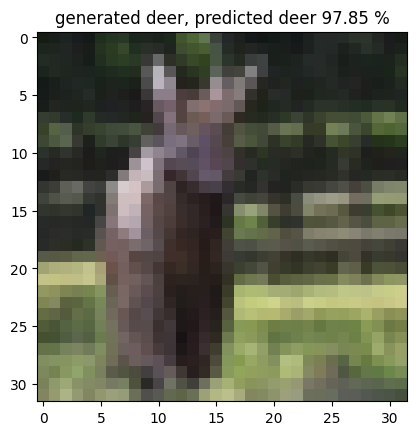

In [15]:
# GENERATOR
with open(path_models/'cifar10.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda() # torch.nn.Module 

# test generator
z = torch.randn([1, G.z_dim]).cuda() # latent codes
label_gen = 4
c = torch.nn.functional.one_hot(torch.tensor([label_gen]).cuda(), num_classes=G.c_dim) # class labels
img = G(z, c, truncation_psi=0.7) # NCHW, float32, dynamic range [-1, +1]
img = postprocess_synthetic_images(img)

# test classifier
classifier = resnet50(pretrained=True).eval().requires_grad_(False).cuda()
logits = classifier(preprocess_images_classifier(img))
probas = torch.softmax(logits, dim=1)
proba, label_pred = torch.max(probas, 1)

# plot
plt.figure()
plt.imshow(img[0].permute(1,2,0).cpu())
plt.title(f'generated {idx_to_label[label_gen]}, predicted {idx_to_label[label_pred.item()]} {100*proba.item():.2f} %')


# DATA
dataset_synthetic = SyntheticImageDataset(G, 5000)
dataloader_calib_synthetic = DataLoader(dataset_synthetic, batch_size)

In [11]:
models = {
    # 'densenet121': densenet121, 'densenet161': densenet161, 'densenet169': densenet169,
    # 'googlenet': googlenet,
    # 'inception_v3': inception_v3,
    # 'mobilenet_v2': mobilenet_v2,
    'resnet18': resnet18, 'resnet34': resnet34, 'resnet50':resnet50, 
    # 'vgg11_bn': vgg11_bn, 'vgg13_bn': vgg13_bn, 'vgg16_bn': vgg16_bn, 'vgg19_bn':vgg19_bn
    }

methods = ['baseline (no calibration)', 'temperature scaling on synthetic data', 'vector scaling on synthetic data']

In [12]:
results_calib = []
results_test = []

for model_name, model in models.items():
    print(model_name)
    classifier = model(pretrained=True).eval().requires_grad_(False).cuda()
    
    for method in methods:
        if method == 'baseline (no calibration)':
            metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_synthetic)
            metrics_test = metrics_from_dataloader(classifier, dataloader_test)
        elif method == 'temperature scaling on synthetic data':
            classifier_calibrated = ModelWithTemperature(classifier).cuda()
            classifier_calibrated.set_temperature(dataloader_calib_synthetic)
            metrics_calib = metrics_from_dataloader(classifier_calibrated, dataloader_calib_synthetic)
            metrics_test = metrics_from_dataloader(classifier_calibrated, dataloader_test)
        elif method == 'vector scaling on synthetic data':
            # Fit vector scaling
            vs = VectorScaling(logit_input=True, logit_constant=0.0)
            logits_list = []
            labels_list = []
            for input, label in dataloader_calib_synthetic:
                input = input.cuda()
                with torch.no_grad():
                    logits = classifier(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cpu()
            labels = torch.cat(labels_list).cpu()
            vs.fit(logits.numpy(), labels.numpy())
            metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_synthetic, vs)
            metrics_test = metrics_from_dataloader(classifier, dataloader_test, vs)
        else:
            raise NotImplementedError

        results_calib.append({'model': model_name, 'method': method, **metrics_calib})
        results_test.append({'model': model_name, 'method': method, **metrics_test})

df_results_calib = pd.DataFrame(results_calib)
df_results_test = pd.DataFrame(results_test)

df_results_test

resnet18
resnet34
resnet50


,model,method,ECE,SCE,RMSCE,ACE,TACE,Accuracy,AUROC,Coverage_for_Accuracy_99,AURC
0,resnet18,baseline (no calibration),0.021062,0.004084,0.059292,0.007242,0.043783,92.979997,0.904217,0.001600,0.011470
1,resnet18,temperature scaling on synthetic data,0.026971,0.004630,0.047200,0.007934,0.035699,92.979997,0.903361,0.000000,0.011581
2,resnet18,vector scaling on synthetic data,0.018808,0.004306,0.029886,0.007275,0.031053,92.940000,0.896747,0.001000,0.012149
3,resnet34,baseline (no calibration),0.028196,0.005673,0.076726,0.008133,0.051741,93.159997,0.899557,0.000000,0.012856
4,resnet34,temperature scaling on synthetic data,0.032432,0.005196,0.062162,0.008713,0.042476,93.159997,0.898770,0.000400,0.012982
5,resnet34,vector scaling on synthetic data,0.021804,0.004020,0.044821,0.007762,0.042007,92.900000,0.890160,0.002799,0.014477
6,resnet50,baseline (no calibration),0.025487,0.005211,0.067500,0.007449,0.047434,93.300003,0.899241,0.003199,0.013043
7,resnet50,temperature scaling on synthetic data,0.028016,0.004661,0.050316,0.007646,0.041611,93.300003,0.898196,0.002000,0.013175
8,resnet50,vector scaling on synthetic data,0.016261,0.003390,0.042326,0.007540,0.037537,93.120000,0.880126,0.002400,0.014589


### Use filtered synthetic data

In [24]:
results_calib = []
results_test = []

for model_name, model in models.items():
    print(model_name)
    classifier = model(pretrained=True).eval().requires_grad_(False).cuda()
    dataset_synthetic_filtered = FilteredSyntheticImageDataset(G, 5000, classifier)
    dataloader_calib_synthetic_filtered = DataLoader(dataset_synthetic_filtered, batch_size)
    
    for method in methods:
        if method == 'baseline (no calibration)':
            metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_synthetic_filtered)
            metrics_test = metrics_from_dataloader(classifier, dataloader_test)
        elif method == 'temperature scaling on synthetic data':
            classifier_calibrated = ModelWithTemperature(classifier).cuda()
            classifier_calibrated.set_temperature(dataloader_calib_synthetic_filtered)
            metrics_calib = metrics_from_dataloader(classifier_calibrated, dataloader_calib_synthetic_filtered)
            metrics_test = metrics_from_dataloader(classifier_calibrated, dataloader_test)
        elif method == 'vector scaling on synthetic data':
            # Fit vector scaling
            vs = VectorScaling(logit_input=True, logit_constant=0.0)
            logits_list = []
            labels_list = []
            for input, label in dataloader_calib_synthetic_filtered:
                input = input.cuda()
                with torch.no_grad():
                    logits = classifier(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cpu()
            labels = torch.cat(labels_list).cpu()
            vs.fit(logits.numpy(), labels.numpy())
            metrics_calib = metrics_from_dataloader(classifier, dataloader_calib_synthetic_filtered, vs)
            metrics_test = metrics_from_dataloader(classifier, dataloader_test, vs)
        else:
            raise NotImplementedError

        results_calib.append({'model': model_name, 'method': method, **metrics_calib})
        results_test.append({'model': model_name, 'method': method, **metrics_test})

df_results_calib = pd.DataFrame(results_calib)
df_results_test = pd.DataFrame(results_test)

df_results_test

resnet18


/gpfsdswork/projects/rech/dcf/ulb98yg/calibration-with-synthetic-data/code/uncertainty_metrics.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return n_s / (n_s + n_d)
/gpfsdswork/projects/rech/dcf/ulb98yg/calibration-with-synthetic-data/code/uncertainty_metrics.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return n_s / (n_s + n_d)


resnet34


/gpfsdswork/projects/rech/dcf/ulb98yg/calibration-with-synthetic-data/code/uncertainty_metrics.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return n_s / (n_s + n_d)
/gpfsdswork/projects/rech/dcf/ulb98yg/calibration-with-synthetic-data/code/uncertainty_metrics.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return n_s / (n_s + n_d)


resnet50


/gpfsdswork/projects/rech/dcf/ulb98yg/calibration-with-synthetic-data/code/uncertainty_metrics.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return n_s / (n_s + n_d)
/gpfsdswork/projects/rech/dcf/ulb98yg/calibration-with-synthetic-data/code/uncertainty_metrics.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return n_s / (n_s + n_d)


,model,method,ECE,SCE,RMSCE,ACE,TACE,Accuracy,AUROC,Coverage_for_Accuracy_99,AURC
0,resnet18,baseline (no calibration),0.021062,4.083766e-03,0.059292,0.007242,0.043783,92.979997,0.904217,0.002000,0.011470
1,resnet18,temperature scaling on synthetic data,0.070200,7.227958e-02,0.073181,0.070751,0.070451,92.979997,0.484006,0.003799,0.074800
2,resnet18,vector scaling on synthetic data,0.071780,6.155395e-02,0.088775,0.064977,0.071875,92.820000,0.516707,0.000000,0.070911
3,resnet34,baseline (no calibration),0.028196,5.673456e-03,0.076726,0.008133,0.051741,93.159997,0.899558,0.001200,0.012856
4,resnet34,temperature scaling on synthetic data,0.099601,1.260638e-10,0.099608,0.169605,0.169605,0.040000,0.544718,0.000000,0.999480
5,resnet34,vector scaling on synthetic data,0.068295,1.410534e-02,0.090052,0.012747,0.068152,93.180000,0.555201,0.000400,0.060098
6,resnet50,baseline (no calibration),0.025487,5.210868e-03,0.067500,0.007449,0.047434,93.300003,0.899241,0.010798,0.013043
7,resnet50,temperature scaling on synthetic data,0.066902,7.020062e-02,0.070033,0.068958,0.067147,93.300003,0.501927,0.001200,0.066913
8,resnet50,vector scaling on synthetic data,0.067355,1.348880e-02,0.113375,0.011514,0.065745,93.240000,0.629373,0.003399,0.055089
